# Functional Connectivity
1. [x] Create a BIDS object
2. [x] Read the Atlas
3. [x] Create BIDSDataGrabber Node
4. [] Create a FC Node which does the following for each subject - 
    5. [] Extract ROI time series.
    6. [] Create FC Maps [ROI x Voxels]
    7. [] Group it in one of two groups: Autistic and TD

In [10]:
from bids.grabbids import BIDSLayout
from nipype.interfaces.fsl import (BET, ExtractROI, FAST, FLIRT, ImageMaths,
                                   MCFLIRT, SliceTimer, Threshold,Info)
from nipype.interfaces.afni import Resample
from nipype.interfaces.io import DataSink
from nipype.pipeline import Node, MapNode, Workflow
from nipype.interfaces.utility import IdentityInterface, Function
import os
from os.path import join as opj
from nipype.interfaces import afni
import nibabel as nib
import numpy as np

In [11]:
# Set paths

path_cwd = os.getcwd()
path_split_list = path_cwd.split('/')
s = path_split_list[0:-1]
s = opj('/',*s) # *s converts list to path, # also it is very important to add '/' in the begining so it is read as directory later
base_directory = opj(s,'result')
data_directory = opj(s,"data/ABIDE-BIDS-Preprocessed/NYU/")

mask_file = os.path.expandvars('$FSLDIR/data/standard/MNI152_T1_2mm_brain_mask.nii.gz')

In [12]:
number_of_subjects = 4 # Number of subjects you wish to preprocess



In [13]:
layout = BIDSLayout(data_directory)

In [14]:
layout.get_subjects() # list the subject IDs of all the subjects

['0050952', '0050953', '0050954', '0050955']

In [15]:
subject_id = layout.get_subjects()[0] # gives the first subject's ID

# Below command gies a list of pathnames
func_file_path = [f.filename for f in layout.get(subject=subject_id, type='bold', extensions=['nii', 'nii.gz'])]
# anat_file_path = [f.filename for f in layout.get(subject=subject_id, type='T1w', extensions=['nii', 'nii.gz'])]


metadata = layout.get_metadata(path=func_file_path[0])

In [16]:
layout.get(subject=subject_id) # I used this to see the 'type' arg for anatomical and functional files 

[File(filename='/home/jovyan/work/preprocess/data/ABIDE-BIDS-Preprocessed/NYU/sub-0050952/anat/sub-0050952_T1w.nii.gz', type='T1w', modality='anat', subject='0050952'),
 File(filename='/home/jovyan/work/preprocess/data/ABIDE-BIDS-Preprocessed/NYU/sub-0050952/func/sub-0050952_task-rest_run-1_bold.nii.gz', type='bold', task='rest', run='1', modality='func', subject='0050952')]

In [17]:
func_file_path# , anat_file_path

['/home/jovyan/work/preprocess/data/ABIDE-BIDS-Preprocessed/NYU/sub-0050952/func/sub-0050952_task-rest_run-1_bold.nii.gz']

In [18]:
# imoportant specs about functional data

TR  = metadata['RepetitionTime']

num_volumes = int(metadata['NumberofMeasurements']) - 4 

metadata; # just add or remove the semicolon to supress or see the output



In [19]:
# code to find how many voxels are in the brain region using the mask

num_brain_voxels = 0
mask_data = nib.load(mask_file)
mask = mask_data.get_data()

x_dim, y_dim, z_dim = mask_data.shape

for i in range(x_dim):
    for j in range(y_dim):
        for k in range(z_dim):
            if mask[i,j,k] == 1:
                num_brain_voxels = num_brain_voxels + 1


In [20]:
num_brain_voxels

228483

In [21]:
metadata
# The metadata doesnot contain the true specs of the brain files as the brain files are now preprocessed.
# Only some fields are consistent now. For example SpacingBetweenSlices, SliceTiming are NOT valid anymore.
# RepetitionTime is still valid.
# NumberofMeasurements is invalid as 4 initial volumes are skipped
# So, use carefully.

{u'AcquisitionDuration': u'6:00',
 u'AcquisitionMatrix': u'80x64',
 u'EchoTime': 0.015,
 u'FieldofViewDimensions': u'240x192',
 u'FieldofViewShape': u'Rectangular',
 u'FlipAngle': 90,
 u'Instructions': u'Most participants were asked to relax with their eyes open, while a white cross-hair against a black background was projected on a screen. However, data were also included for some individuals who were asked to keep their eyes closed',
 u'MagneicFieldStrength': 3,
 u'Manufacturer': u'Siemens',
 u'ManufacturersModelName': u'Allegra',
 u'NumberOfSlices': 33.0,
 u'NumberofMeasurements': 180.0,
 u'ParallelAcquisition': u'No',
 u'PhaseEncodingDirection': u'i',
 u'PixelBandwidth': 3906.0,
 u'PixelSpacing': u'3x3',
 u'PlaneOrientationSequentialuence': u'Axial > Coronal -23',
 u'PulseSequenceType': u'EPI',
 u'ReceiveCoilType': u'Head',
 u'RepetitionTime': 2.0,
 u'ScanOptions': u'FS',
 u'SliceAcquisitionOrder': u'Interleaved Ascending',
 u'SliceEncodingDirection': u'k',
 u'SliceThickness': 4.0,

## Atlas

In [22]:
# Put in the path of atlas you wish to use
atlasPath = opj(s,'atlas/Full_brain_atlas_thr0-2mm/fullbrain_atlas_thr0-2mm.nii.gz')

In [23]:
# Read the atlas
atlasObject = nib.load(atlasPath)
atlas = atlasObject.get_data()

### Lets see the number of regions in the atlas and display the atlas.

In [24]:
num_ROIs = int((np.max(atlas) - np.min(atlas) ))

print('Min Index:', np.min(atlas),'Max Index', np.max(atlas))
print('Total Number of Parcellations = ',num_ROIs)

('Min Index:', 0.0, 'Max Index', 274.0)
('Total Number of Parcellations = ', 274)


Index 0.0 denotes the regin of the scan which does not contain brain voxel.

Let's display the atlas.

/opt/conda/envs/python2/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/opt/conda/envs/python2/lib/python2.7/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


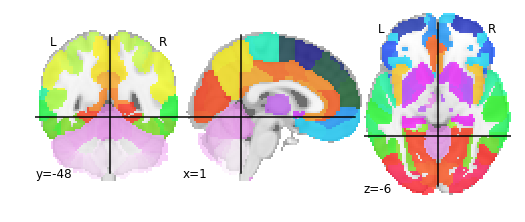

In [25]:
%matplotlib inline
from nilearn import plotting
plotting.plot_roi(atlasObject)


## Read the data files using BIDSGrabber

In [17]:
# List of Subject IDs

subject_list = (layout.get_subjects())[0:number_of_subjects]

Create our own custom function - BIDSDataGrabber using a Function Interface.

In [18]:
def get_nifti_filenames(subject_id,data_dir):
#     Remember that all the necesary imports need to be INSIDE the function for the Function Interface to work!
    from bids.grabbids import BIDSLayout
    
    layout = BIDSLayout(data_dir)
    
    anat_file_path = [f.filename for f in layout.get(subject=subject_id, type='T1w', extensions=['nii', 'nii.gz'])]
    func_file_path = [f.filename for f in layout.get(subject=subject_id, type='bold', extensions=['nii', 'nii.gz'])]
    
    return anat_file_path[0],func_file_path[0]

# Refer to Supplementary material section One for info on arguments for layout.get()

Wrap it inside a Node

In [19]:
BIDSDataGrabber = Node(Function(function=get_nifti_filenames, input_names=['subject_id','data_dir'],
                                output_names=['anat_file_path','func_file_path']), name='BIDSDataGrabber')
BIDSDataGrabber.iterables = [('subject_id',subject_list)]
BIDSDataGrabber.inputs.data_dir = data_directory

In [20]:
# To test the function wrapped in the node

# BIDSDataGrabber.inputs.data_dir = data_directory
# BIDSDataGrabber.inputs.subject_id = layout.get_subjects()[0] # gives the first subject's ID
# res = BIDSDataGrabber.run()

# res.outputs

## Create a FC node

This node:
1. Exracts the average time series of the brain ROI's using the atlas and stores 
    it as a matrix of size [ROIs x Volumes].
2. Extracts the Voxel time series and stores it in matrix of size [Voxels x Volumes]


TODO: Check how nifti masker works. How does it summarize an ROI? Does it take the mean of all the voxels?

In [21]:
# Initialize a matrix of ROI time series and voxel time series

ROI_matrix = np.zeros((num_ROIs, num_volumes))
voxel_matrix = np.zeros((num_brain_voxels, num_volumes))

In [22]:
func_file_path[0].split('/')[-1].split('.')[0].split('_')[0].split('-')[1]

'0050952'

In [23]:
# Fill up the voxel_matrix 

brain_data = nib.load(func_file_path[0])
brain = brain_data.get_data()

# %time gives incorrect time. check!
x_dim, y_dim, z_dim, _ = brain.shape

voxel_counter = 0
for i in range(x_dim):
    for j in range(y_dim):
        for k in range(z_dim):
            if mask[i,j,k] == 1:
                voxel_matrix[voxel_counter,:] = brain[i,j,k,:] 
                voxel_counter = voxel_counter + 1




In [24]:
# Fill up the ROI_matrix
% time
# Keep track of number of voxels per ROI as well by using an array - num_voxels_in_ROI[]

num_voxels_in_ROI = np.zeros((num_ROIs,1)) # A column arrray containing number of voxels in each ROI

for i in range(x_dim):
    for j in range(y_dim):
        for k in range(z_dim):
            label = int(atlas[i,j,k]) - 1
            if label != -1:
                ROI_matrix[label,:] = np.add(ROI_matrix[label,:], brain[i,j,k,:])
                num_voxels_in_ROI[label,0] = num_voxels_in_ROI[label,0] + 1
                
ROI_matrix = np.divide(ROI_matrix,num_voxels_in_ROI) # Check if divide is working correctly


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.01 µs


In [25]:
# Calculate the Correlation matrix [ROI x Voxels]
# Check if numpy's correlation function expects the mean centered data or not
# -> Couldn't find out. So make your own function to calculate pearson correlation 

In [26]:
X, Y = ROI_matrix, voxel_matrix
# Subtract mean from X and Y

X = np.subtract(X, np.mean(X))
Y = np.subtract(Y, np.mean(Y))

temp1 = np.dot(X,Y.T)
print "Temp1 Done"
temp2 = np.sqrt(np.multiply(X,X))
print "Temp2 Done"
temp3 = np.sqrt(np.multiply(Y,Y)).T
print "Temp3 Done"
temp4 = np.dot(temp2,temp3)
print "Temp4 Done"
pear = np.divide(temp1, (temp4+0.0001))
print "Pear Done"

Temp1 Done
Temp2 Done
Temp3 Done
Temp4 Done
Pear Done


In [27]:
pear.shape

(274, 228483)

Looks gr8!

1. Now, Lets encapsulate the above code inside a function and then in a node that will take as input the func file path and creates the FC map for that.

2. Next Node will be a join node that will create a two groups

3. Can we do the 1step by using some other node type like map?

In [28]:
# Create a the function

def pear_coff(in_file, atlas, num_brain_voxels, mask):
    
    # imports
    import numpy as np
    import nibabel as nib
    import os
    from os.path import join as opj
    
#     # Put in the path of atlas you wish to use
#     atlasPath = opj(s,'atlas/Full_brain_atlas_thr0-2mm/fullbrain_atlas_thr0-2mm.nii.gz')
    
#     # Read the atlas
#     atlasObject = nib.load(atlasPath)
#     atlas = atlasObject.get_data()
    os.chdir('/home/jovyan/work/preprocess/temp/')
    
    
    num_ROIs = int((np.max(atlas) - np.min(atlas) ))

#     print('Min Index:', np.min(atlas),'Max Index', np.max(atlas))
#     print('Total Number of Parcellations = ',num_ROIs)
    
    
    
    # Read the brain in_file

    brain_data = nib.load(in_file)
    brain = brain_data.get_data()

    # %time gives incorrect time. check!
    x_dim, y_dim, z_dim, num_volumes = brain.shape

    
    # Initialize a matrix of ROI time series and voxel time series

    ROI_matrix = np.zeros((num_ROIs, num_volumes))
    voxel_matrix = np.zeros((num_brain_voxels, num_volumes))
    
    # Fill up the voxel_matrix 
#     print 'Filling up the voxel matrix'
    voxel_counter = 0
    for i in range(x_dim):
        for j in range(y_dim):
            for k in range(z_dim):
                if mask[i,j,k] == 1:
                    voxel_matrix[voxel_counter,:] = brain[i,j,k,:] 
                    voxel_counter = voxel_counter + 1
    
    # Fill up the ROI_matrix
    
#     print 'FIlling up the ROI matrix'
    # Keep track of number of voxels per ROI as well by using an array - num_voxels_in_ROI[]

    num_voxels_in_ROI = np.zeros((num_ROIs,1)) # A column arrray containing number of voxels in each ROI

    for i in range(x_dim):
        for j in range(y_dim):
            for k in range(z_dim):
                label = int(atlas[i,j,k]) - 1
                if label != -1:
                    ROI_matrix[label,:] = np.add(ROI_matrix[label,:], brain[i,j,k,:])
                    num_voxels_in_ROI[label,0] = num_voxels_in_ROI[label,0] + 1

    ROI_matrix = np.divide(ROI_matrix,num_voxels_in_ROI) # Check if divide is working correctly
    
#     print 'Done'
    # Calculate the Correlation matrix [ROI x Voxels]
    X, Y = ROI_matrix, voxel_matrix
    
    # Subtract mean from X and Y
    X = np.subtract(X, np.mean(X))
    Y = np.subtract(Y, np.mean(Y))

    temp1 = np.dot(X,Y.T)
    temp2 = np.sqrt(np.multiply(X,X))
    temp3 = np.sqrt(np.multiply(Y,Y)).T
    temp4 = np.dot(temp2,temp3)
    pear_matrix = np.divide(temp1, (temp4+0.0001))
#     print "Pear Done"
    
    sub_id = in_file.split('/')[-1].split('.')[0].split('_')[0].split('-')[1]
    
    fc_file_name = sub_id + 'fc_map'
    
    np.save(fc_file_name, pear_matrix)
    
    pear_matrix_file = opj(os.getcwd(),fc_file_name) # path
    return pear_matrix_file
#     pear_matrix = 1
#     return pear_matrix
    
    

In [27]:
import os
from os.path import join as opj
fc_file_name ='varun'
fc_file_path = opj(os.getcwd(),fc_file_name)
fc_file_path

'/home/jovyan/work/preprocess/Autism-Connectome-Analysis/varun'

In [29]:
# Create the Node and set default valus to

pearcoff = Node(Function(function=pear_coff, input_names=['in_file','atlas','num_brain_voxels','mask'],
                                output_names=['pear_matrix']), name='pearcoff')

pearcoff.inputs.in_file = func_file_path[0]
pearcoff.inputs.atlas = atlas
pearcoff.inputs.num_brain_voxels = num_brain_voxels
pearcoff.inputs.mask = mask

In [30]:

pearcoff.run()

171020-19:00:28,516 workflow INFO:
	 Executing node pearcoff in dir: /tmp/tmp5HP81o/pearcoff


In [32]:
# Okay Lets try one more time:
# Create a the function

def pear_coff_2(in_file, atlas_file, mask_file):
    # code to find how many voxels are in the brain region using the mask
    
        # imports
    import numpy as np
    import nibabel as nib
    import os
    from os.path import join as opj

    
    os.chdir('/home/jovyan/work/preprocess/temp/')
    
    num_brain_voxels = 0
    mask_data = nib.load(mask_file)
    mask = mask_data.get_data()

    x_dim, y_dim, z_dim = mask_data.shape

    for i in range(x_dim):
        for j in range(y_dim):
            for k in range(z_dim):
                if mask[i,j,k] == 1:
                    num_brain_voxels = num_brain_voxels + 1
                    
    atlasPath = atlas_file
    # Read the atlas
    atlasObject = nib.load(atlasPath)
    atlas = atlasObject.get_data()
    
    num_ROIs = int((np.max(atlas) - np.min(atlas) ))

#     print('Min Index:', np.min(atlas),'Max Index', np.max(atlas))
#     print('Total Number of Parcellations = ',num_ROIs)

    # Read the brain in_file

    brain_data = nib.load(in_file)
    brain = brain_data.get_data()

    x_dim, y_dim, z_dim, num_volumes = brain.shape
    
    # Initialize a matrix of ROI time series and voxel time series

    ROI_matrix = np.zeros((num_ROIs, num_volumes))
    voxel_matrix = np.zeros((num_brain_voxels, num_volumes))
    
    # Fill up the voxel_matrix 
    print('Filling up voxel matrix')
    voxel_counter = 0
    for i in range(x_dim):
        for j in range(y_dim):
            for k in range(z_dim):
                if mask[i,j,k] == 1:
                    voxel_matrix[voxel_counter,:] = brain[i,j,k,:] 
                    voxel_counter = voxel_counter + 1

                    
    # Fill up the ROI_matrix
    print('Filling up voxel matrix')
    # Keep track of number of voxels per ROI as well by using an array - num_voxels_in_ROI[]

    num_voxels_in_ROI = np.zeros((num_ROIs,1)) # A column arrray containing number of voxels in each ROI

    for i in range(x_dim):
        for j in range(y_dim):
            for k in range(z_dim):
                label = int(atlas[i,j,k]) - 1
                if label != -1:
                    ROI_matrix[label,:] = np.add(ROI_matrix[label,:], brain[i,j,k,:])
                    num_voxels_in_ROI[label,0] = num_voxels_in_ROI[label,0] + 1

    ROI_matrix = np.divide(ROI_matrix,num_voxels_in_ROI) # Check if divide is working correctly

    X, Y = ROI_matrix, voxel_matrix
    # Subtract mean from X and Y

    X = np.subtract(X, np.mean(X))
    Y = np.subtract(Y, np.mean(Y))

    temp1 = np.dot(X,Y.T)
    print ("Temp1 Done")
    temp2 = np.sqrt(np.multiply(X,X))
    print ("Temp2 Done")
    temp3 = np.sqrt(np.multiply(Y,Y)).T
    print ("Temp3 Done")
    temp4 = np.dot(temp2,temp3)
    print ("Temp4 Done")
    coff_matrix = np.divide(temp1, (temp4+0.0001))
    print ("Pear Done")
#     print ('Over!')
#     coff_matrix = 1
    sub_id = in_file.split('/')[-1].split('.')[0].split('_')[0].split('-')[1]
    
    fc_file_name = sub_id + 'fc_map'
    
    np.save(fc_file_name, coff_matrix)
    
    coff_matrix_file = opj(os.getcwd(),fc_file_name) # path
    return coff_matrix_file



In [33]:
# Again Create the Node and set default valus to

pearcoff = Node(Function(function=pear_coff_2, input_names=['in_file','atlas_file','mask_file'],
                                output_names=['coff_matrix_file']), name='pearcoff')

pearcoff.inputs.in_file = func_file_path[0]
pearcoff.inputs.atlas_file = atlasPath
# pearcoff.inputs.num_brain_voxels = num_brain_voxels
pearcoff.inputs.mask_file = mask_file

In [34]:
%time
pearcoff.run()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 4.05 µs
171020-19:03:56,201 workflow INFO:
	 Executing node pearcoff in dir: /tmp/tmpIizkv8/pearcoff
Filling up voxel matrix
Filling up voxel matrix
Temp1 Done
Temp2 Done
Temp3 Done
Temp4 Done
Pear Done


Above are the two ways the node can be created:
> You can pass the whole matrix as input (or)  
> You can pass just the file name and let the function compute the matrix

The comparison between two are left to be done. Which of the approach is faster. 2nd approach seemed faster. Need to check.

**Takeaway:** The system hangs if you are trying to return big matrices. Solution is to save the matrix and return the path of it.


In [ ]:
atlas.max()

In [ ]:
ROI_matrix.shape

In [ ]:
voxel_matrix.shape

In [ ]:
brain.shape

In [ ]:
91*109*91

In [ ]:
num_voxels_in_ROI.max()

In [1]:
!pwd

/home/jovyan/work/preprocess/Autism-Connectome-Analysis
